## Import Dependencies

In [1]:
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import gym
from collections import deque
import matplotlib.pyplot as plt

import io
import base64
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
from IPython.display import HTML
from IPython import display as ipythondisplay

if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

## Loading CartPole Environment

In [2]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


## Initial Observation

In [3]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.00657013 -0.04980867 -0.01961917 -0.0296322 ]


In [4]:
observation, reward, done, info = env.step(0)
def printInfo(observation, reward, done):
    print("New observations after choosing action 0:", observation)
    print("Reward for this step:", reward)
    print("Is this round done?", done)

## What is Deep Q learning

Q-learning focuses on learning Q-function to evaluate state-action pairs while Deep Q learning replaces this with deep neural network, which is deep Q-network to approximate this Q-function.

In this Deep Q-Learning project, we create a loss function that compares our Q-value prediction and Q-target and uses Adam optimizer which is a type of gradient descent optimizer to update the weights of our deep q network to approximate the Q-value. In other words, Deep Q-learning is about learning the optimal Q-function is performed by minimizing the squared Bellman loss (error), which represents the error between the predicted Q-values and the target Q-values.

In DQN training, it involves the use of historical data. Our DQN project implemented Replay memory that stores the past experiences (state transitions, actions, rewards, and next states), which will then be used in the training process using a gradient descent update. In the training process, a batch of experience is randomly sampled from the memory buffer defined in Replay Memory. The batch size is also specified in the code in this project. This random sampling is to counter temporal correlaton, that is the correlation between consecutive experiences or data points that occur over time, thereby prevent overfitting in the training process. Not only, the buffer memory is used to allows the model to train from the past experiences, but also allow the model to relearn from the past experiences, to ensure effective training instead of "learning once then discard the experience"

Additionally, we also make use of the target network in the DQN training. Target network is to stabilize the learning process.




## Mathematical Equation in Training:



Mathematical equation to calculate the target Q-value:

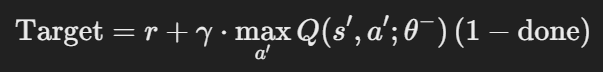


where :

- s: current state
- 𝑎: Action taken in state 𝑠
- r: Immediate reward received after taking action 𝑎
- s': Next state resulting from the action.
- γ: Discount factor that determines the importance of future rewards (
0≤γ<1).
- max𝑎′𝑄(𝑠′,𝑎′;𝜃−): Maximum estimated Q-value for the next state 𝑠′over all possible actions 𝑎′, as predicted by the target network with parameters 𝜃−
- done:  A flag indicating whether 𝑠′is a terminal state. When done=1, no future rewards are considered.
- θ: Parameters (weights) of the policy network.
- θ −: Parameters of the target network, updated periodically from the policy network.


The loss function used to train the network is the mean squared error (MSE) between the current Q-value and the target:

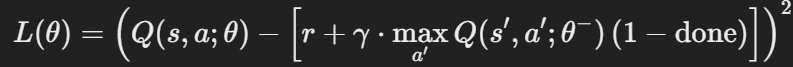

where L(θ) is the square root of [(predicted q value for taking action a in state s, which estimated by policy network) - (target q-value)]


in other words, L(θ) is the (mean squared error)between the current Q-value and the expected Q-value.

Recall that: in this project, we use Adam optimizer to update neural network in the training process.


## Task 1: Development of Deep Q-Learning Based RL Agent

### Defining DQN class



In Pytorch, all neural network models should inherit from nn.module

DQN attributes:

*   input_dim: the number of input features (or state dimensions)
*   hidden_dim: the number of nodes in the hidden layer
*   output_dim: the number of output actions (or outputs)
* fc1: The first fully connected (linear) layer that maps the input states (with input_dim features) to a hidden representation of size hidden_dim.

* fc2: A second fully connected layer that takes the hidden representation from fc1 and further processes it, maintaining the size of hidden_dim.

* out: The final fully connected layer that maps the processed hidden features to the output layer, providing the Q-values for each action (with dimension output_dim).


DQN's forward function:  

*   refers to the neural network's process of taking a state as input and outputting a vector of Q-values (predicted action values) for each possible action in that state.
*  self.fc1(x) refers to passing the data through the first layer called self.fc1
* self.fc2(x): The output from the first layer (after ReLU) is then fed into the second fully connected layer (fc2) for further transformation.
*   torch.relu refers to applying rectified linear unit (ReLU) activation.
After each linear transformation, the ReLU activation function is applied. This non-linear activation introduces non-linearity into the model, allowing it to learn more complex patterns.
*   self.out(x) means pass the processed features to the output layer to  generate the Q-values corresponding to each possible action. No activation is applied here since raw Q-values are needed for decision-making in reinforcement learning.






In [5]:
# Define DQN network
# DQN network here is a subclass of torch.nn.module
class DQN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        # input_dim is the number of observation inputs
        # hidden_dim is the number of hidden units
        # out_layer is the number of possible actions
        super(DQN, self).__init__()

        # define the first fully connected layer that takes observation inputs
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)

        # define the second fully connected layer that takes the output of the first layer
        # and maps it to another hidden representation of size 'hidden_dim'
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)

        # Define the output layer that maps the final hidden representation to the Q-values for each action
        self.out = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # self.fc1(x) means passing the data through the first layer called self.fc1
        # apply ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x) # return calculated output

### Defining replay memory


In fact, if the agent interacts with the environment (state, action, reward and next state), then update the neural network and finally discard them, it is not efficient training.

Therefore, we create replay memory, a memory replay buffer to store experience samples that we can reuse during the training. In other words, the same transition contributes to muliple training iteration instead of discarding an experience after a single use.



In [30]:
# Replay memory for experience replay
class ReplayMemory:
    # capacity is the maximum number of transitions that the memory can hold
    # when the memory is full and new transition is added, then the oldest transition will be automatically replaced
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Helper function for step_env

In [7]:
def step_env(env, action):
    result = env.step(action)
    # If 4 values, legacy gym: (next_state, reward, done, info)
    if len(result) == 4:
        next_state, reward, done, info = result
    # If 5 values, new gym API: (next_state, reward, terminated, truncated, info)
    elif len(result) == 5:
        next_state, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:
        raise ValueError("Unexpected number of values returned from env.step()")
    return next_state, reward, done, info

### Defining Train_Dqn function

Important Note:

1. batch size is the number of experience samples taken from replay memory to updaate the neural network at each learning step. Why do we need to have this?

*   because to prevent overfitting by sampling the experiences randomly
*   when an agent collects experiences sequentially, consecutive samples are highly correlated (temporal correlation), potentially causing the update of neural network overfit to recent states and actions

2. "lr = 0.0001" in the code below is the learning rate for the optimizer. In order words, it is how much is the weight of the network get updated during training. recall that: The optimizer we used here is Adam optimizer.

3. Adam optimizer is to adapt learning rate for individual parameters of the neural network, for eg, (weights and biases of the neural network) with an aim to converges faster.

*   Convergence means that as training progresses, the changes in the loss function become minimal, indicating that the model's parameters have stabilized and further training produces only negligible improvements









In [8]:
# Training function for Deep Q-Learning on CartPole-v1
def train_dqn(
    env,
    max_steps=500,   #The maximum number of steps allowed in each episode.
    batch_size=64,
    gamma=0.99,      #discount factor that determines how much future rewards are valued compared to immediate rewards.


    epsilon_start=1.0, #The initial exploration rate, meaning the agent starts by exploring completely randomly.
    epsilon_end=0.01,  #The minimum exploration rate, ensuring the agent always has a small probability of choosing a random action.
    epsilon_decay=0.995, #The rate at which the exploration rate decreases after each episode,
                         #gradually shifting the focus from exploration to exploitation.


    lr=0.001,
    target_update_freq=10,  #How often the target network is updated to match the current Q-network, which helps stabilize learning.

    memory_capacity=10000,
    max_episodes=100000,  # safeguard to avoid infinite loops
    target_avg_reward=500  # target average reward over 10 episodes set to 500
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = env.observation_space.shape[0]     #CartPole has 4 observation inputs
    output_dim = env.action_space.n                #Cartpole has two actions
    hidden_dim = 64                                # Hidden layer size

    # Initialize policy and target networks
    # target network is a copy of the policy network that is updated less frequently to provide stable target Q-values
    policy_net = DQN(input_dim, hidden_dim, output_dim).to(device)
    target_net = DQN(input_dim, hidden_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    #An Adam optimizer is used for gradient descent
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    #a replay memory is created to store past experiences
    memory = ReplayMemory(memory_capacity)

    epsilon = epsilon_start
    rewards_history = []
    rewards_deque = deque(maxlen=10)  # moving average over the last 10 episodes

    #Episode Loop
    for episode in range(max_episodes):
        # reset the env and set the initial state as a tensor object
        result = env.reset(return_info=True)
        state = result[0] if isinstance(result, tuple) else result
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cumulative_reward = 0

        for t in range(max_steps):
            ##########################SAMPLING######################################
            # ε-greedy action selection:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    action = q_values.argmax().item() ## pick an action with highest Q-value

            #Step the environment using the chosen action above
            next_state, reward, done, info = step_env(env, action)
            cumulative_reward += reward

            # If next_state is a tuple, extract the observation, then convert it into tensor
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory.
            memory.push((state, action, reward, next_state_tensor, done))
            state = next_state_tensor



            ############################Training####################################
            # only train if there is enough size of experience replay

            if len(memory) >= batch_size:

                ### select a random batch in the memory to update the network policy
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)


                # just concatenate since batch state is already a tensor when stored in the memory
                batch_state = torch.cat(batch_state)
                batch_next_state = torch.cat(batch_next_state)

                # the rest converted into PyTorch tensor
                batch_action = torch.tensor(batch_action, dtype=torch.int64, device=device).unsqueeze(1)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32, device=device).unsqueeze(1)
                batch_done = torch.tensor(batch_done, dtype=torch.float32, device=device).unsqueeze(1)

                # learn from this batch using a gradient descent update step.

                # Compute Q(s, a) using the policy network.
                # Q(s,a;θ)=policy_net(s) evaluated at action a
                current_q = policy_net(batch_state).gather(1, batch_action)

                # Compute maximum Q value for the next state from the target network.
                # (max a') Q(s',a';θ-) = max (target_net(s'))
                next_q = target_net(batch_next_state).max(1)[0].detach().unsqueeze(1)


                # Compute target Q values. #batch_done returns 0 or 1, if it returns 1, means reach terminal state, therefore no future reward
                # target Q values = immediate reward + discounted(max q value from next state); if batch done = 1, no future reward
                expected_q = batch_reward + gamma * next_q * (1 - batch_done)

                # Compute loss (mean squared error)between the current Q-value and the expected Q-value.
                loss = F.mse_loss(current_q, expected_q)

                # reset all the gradients of the parameters in the  policy network to zero
                optimizer.zero_grad()
                # compute the gradient for the loss function with respect to each parameter in the network by performing backpropagation
                loss.backward()
                # Once the gradients are computed, the optimizer updates the parameters of the policy network
                optimizer.step()

            if done:
                break

        # Decay epsilon and record reward.
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards_history.append(cumulative_reward)
        rewards_deque.append(cumulative_reward)

        # Update the target network periodically by copying the weights from policy network to target network
        if (episode + 1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())


        if episode % 100 == 0:
            avg_reward = np.mean(rewards_deque)
            print(f"Episode {episode}: Reward = {cumulative_reward}, Average (last 10) = {avg_reward:.2f}")

        # Check if the average reward over the last 10 episodes meets the target.
        if len(rewards_deque) == 10 and np.mean(rewards_deque) >= target_avg_reward:
            print(f"Episode {episode+1}: Average reward = {np.mean(rewards_deque):.2f}")
            break

    return policy_net, rewards_history


### Defining Evaluation function

In [9]:
def evaluate_dqn_agent(env, policy_net, episodes=10, max_steps=500):
    """
    Evaluate the trained DQN agent on the given environment.

    Parameters:
        env: Gym environment for evaluation.
        policy_net: The trained DQN policy network.
        episodes: Number of evaluation episodes.
        max_steps: Maximum steps per episode.

    Returns:
        List of cumulative rewards for each episode.
    """
    # Choose the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net.eval()  # Set the network in evaluation mode.
    rewards = []

    for episode in range(episodes):
        # Reset the environment and handle the new Gym API format.
        result = env.reset(return_info=True)
        state = result[0] if isinstance(result, tuple) else result
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cumulative_reward = 0

        for t in range(max_steps):
            # Use the policy network to select an action.
            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.argmax().item()
            next_state, reward, done, info = step_env(env, action)
            cumulative_reward += reward
            # Handle possible tuple in the next state.
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            if done:
                break

        rewards.append(cumulative_reward)
        print(f"Evaluation Episode {episode+1}: Reward = {cumulative_reward}")

    avg_reward = np.mean(rewards)
    print(f"Average Reward over {episodes} evaluation episodes: {avg_reward:.2f}")
    return rewards


Episode 0: Reward = 29.0, Average (last 10) = 29.00
Episode 100: Reward = 127.0, Average (last 10) = 78.90
Episode 200: Reward = 103.0, Average (last 10) = 92.70
Episode 300: Reward = 117.0, Average (last 10) = 106.60
Episode 400: Reward = 107.0, Average (last 10) = 98.80
Episode 500: Reward = 162.0, Average (last 10) = 157.40
Episode 600: Reward = 95.0, Average (last 10) = 95.30
Episode 700: Reward = 171.0, Average (last 10) = 112.00
Episode 800: Reward = 119.0, Average (last 10) = 123.50
Episode 900: Reward = 242.0, Average (last 10) = 445.50
Episode 911: Average reward = 500.00


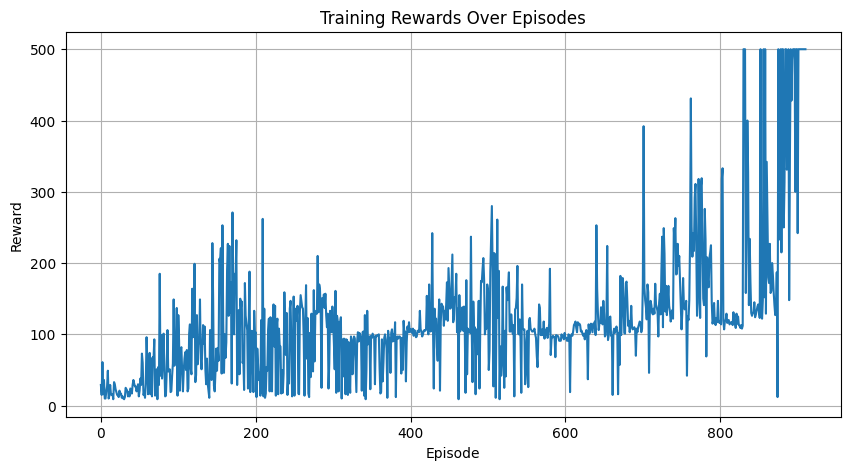

In [11]:
# Main execution: Train and evaluate the DQN agent until solved
env_train = gym.make("CartPole-v1")
policy_net, training_rewards = train_dqn(env_train)
env_train.close()

plt.figure(figsize=(10,5))
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Rewards Over Episodes")
plt.grid(True)
plt.show()


In [24]:
# Setup the evaluation environment with video recording enabled.
video_folder = "evaluation_videos"
# Define which episode to record. For example, if episodes=10, record the 10th episode (index 9).
eval_episode_to_record = 100

env = gym.make("CartPole-v1")
env = RecordVideo(env,
                  video_folder=video_folder,
                  episode_trigger=lambda ep: ep == eval_episode_to_record,
                  name_prefix="evaluation")

# Evaluate the agent.
# Assume 'policy_net' is your pre-trained DQN network.
evaluation_rewards = evaluate_dqn_agent(env, policy_net, episodes=100)
env.close()

Evaluation Episode 1: Reward = 500.0
Evaluation Episode 2: Reward = 500.0
Evaluation Episode 3: Reward = 500.0
Evaluation Episode 4: Reward = 500.0
Evaluation Episode 5: Reward = 500.0
Evaluation Episode 6: Reward = 500.0
Evaluation Episode 7: Reward = 500.0
Evaluation Episode 8: Reward = 500.0
Evaluation Episode 9: Reward = 500.0
Evaluation Episode 10: Reward = 500.0
Evaluation Episode 11: Reward = 500.0
Evaluation Episode 12: Reward = 500.0
Evaluation Episode 13: Reward = 500.0
Evaluation Episode 14: Reward = 500.0
Evaluation Episode 15: Reward = 500.0
Evaluation Episode 16: Reward = 500.0
Evaluation Episode 17: Reward = 500.0
Evaluation Episode 18: Reward = 500.0
Evaluation Episode 19: Reward = 500.0
Evaluation Episode 20: Reward = 500.0
Evaluation Episode 21: Reward = 500.0
Evaluation Episode 22: Reward = 500.0
Evaluation Episode 23: Reward = 500.0
Evaluation Episode 24: Reward = 500.0
Evaluation Episode 25: Reward = 500.0
Evaluation Episode 26: Reward = 500.0
Evaluation Episode 27

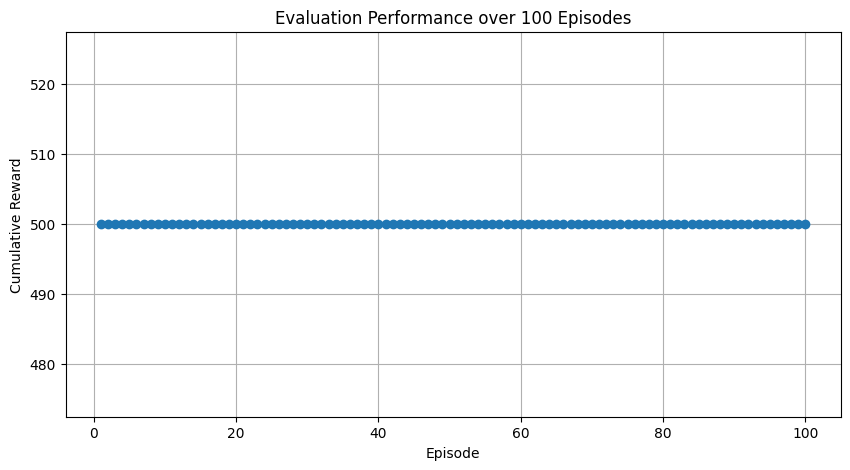

Average Reward over 100 evaluation episodes: 500.00


In [25]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, eval_episode_to_record + 1), evaluation_rewards, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Evaluation Performance over 100 Episodes")
plt.grid(True)
plt.show()

# Also print the average reward
avg_reward = np.mean(evaluation_rewards)
print(f"Average Reward over {eval_episode_to_record} evaluation episodes: {avg_reward:.2f}")

### Evaluation of Video

In [27]:
from IPython.display import Video
Video("./evaluation-episode-100.mp4", embed=True)

In [28]:
print(policy_net)

DQN(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)


In [29]:
# Save the trained policy network
torch.save(policy_net.state_dict(), "policy_net.pth")
print("Policy network exported successfully!")


Policy network exported successfully!
